In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(os.environ["CUDA_VISIBLE_DEVICES"],torch.cuda.device_count(), torch.cuda.current_device())

1 1 0


In [2]:
import os
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from tqdm import tqdm
from torch import optim
# from utils import *
# from modules import UNet
import logging
from torch.utils.tensorboard import SummaryWriter

import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
from torch import optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import math

print(torch.__version__)
torch.cuda.is_available()

import h5py


1.12.0+cu102


In [3]:
class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=[32, 16, 16], device="cuda"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model, n):
        logging.info(f"Sampling {n} new images....")
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, self.img_size[0], self.img_size[1],self.img_size[2])).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        # x = (x.clamp(-1, 1) + 1) / 2
        # x = x.clamp(min=0)
        # x = (x * 255).type(torch.uint8)
        return x
    
    # def sample(self, model, n, labels, cfg_scale=3):
    #     logging.info(f"Sampling {n} new images....")
    #     model.eval()
    #     with torch.no_grad():
    #         x = torch.randn((n, self.img_size[0], self.img_size[1],self.img_size[2])).to(self.device)
    #         for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
    #             t = (torch.ones(n) * i).long().to(self.device)
    #             predicted_noise = model(x, t, labels)
    #             if cfg_scale > 0:
    #                 uncond_predicted_noise = model(x, t, None)
    #                 predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, cfg_scale)
    #             alpha = self.alpha[t][:, None, None, None]
    #             alpha_hat = self.alpha_hat[t][:, None, None, None]
    #             beta = self.beta[t][:, None, None, None]
    #             if i > 1:
    #                 noise = torch.randn_like(x)
    #             else:
    #                 noise = torch.zeros_like(x)
    #             x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
    #     model.train()
    #     # x = (x.clamp(-1, 1) + 1) / 2
    #     # x = (x * 255).type(torch.uint8)
        # x = x.clamp(0, 1)
    #     return x

In [4]:
is_wandb = True
if is_wandb:
    import wandb
    wandb.init(project="diff_protein_gen", entity="jathurshan_0330")
    wandb.run.name = "Test_dist_ref_generation_unconditional_without_input_masking"
    wandb.run.save()
    # "Finetuning only classification head Ki67 using SIMCLR Pretrained Model"
    exp_path = f"./model_checkpoints/{wandb.run.name}"
    if not os.path.exists(exp_path):
        os.mkdir(exp_path)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jathurshan_0330. Use `wandb login --relogin` to force relogin
/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help` for usage information.


/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help` for usage information.




wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


## Data Loading

In [5]:
file_list = glob.glob("/home/jupyter-jathurshan/Protein_extracted_data/*.h5")
file_list.sort()
print(len(file_list))


new_list = []
for i in file_list:
    with h5py.File(i, "r") as f:
            # dist_ref = np.array(f.get('dist_ref'))
            sse = np.array(f.get('sse'))
            # seq = np.array(f.get('seq'))
            # mask = np.array(f.get('mask'))
            f.close()
    if len(sse.shape)!=0:
        if sse.shape[-1]!=0:
            new_list.append(i)
print(len(new_list))#,error_list)


c = 0
max_value = 0
min_value = 100000

for i in new_list:
    with h5py.File(i, "r") as f:
            dist_ref = np.expand_dims(np.array(f.get('dist_ref')),axis=0)
    if dist_ref.max()>max_value:
        max_value = dist_ref.max()
    if dist_ref.min()<min_value:
        min_value = dist_ref.min()
print(min_value,max_value)

7555
4918
0.0 227.59543138843227


In [6]:
#15051
file_list = new_list#glob.glob("/home/jupyter-jathurshan/Protein_extracted_data/*.h5")
# file_list.sort()
# print(len(file_list))

train_file_list = file_list[:int(len(file_list)*0.8)]
val_file_list = file_list[int(len(file_list)*0.8):int(len(file_list)*0.9)]
test_file_list = file_list[int(len(file_list)*0.9):]

print(len(train_file_list),len(val_file_list),len(test_file_list))

3934 492 492


In [7]:
def plot_sub_plots(rows,columns,img_list,title_list,cmap = 'inferno'):
    fig, axs = plt.subplots(rows, columns, figsize = (columns*10,rows*10))
    if rows == 1:
        for i in range(len(img_list)):
            im1 = axs[i].imshow(img_list[i],cmap=cmap)
            axs[i].set_title(f"{title_list[i]}")
            plt.colorbar(im1, ax=axs[i])#,shrink = 0.3
    else:
        for i in range(len(img_list)):
            im1 = axs[i//columns][i%columns].imshow(img_list[i],cmap=cmap)
            axs[i//columns][i%columns].set_title(f"{title_list[i]}")
            plt.colorbar(im1, ax=axs[i//columns][i%columns])#,shrink = 0.3)
    # plt.show()
    return fig


In [8]:
import h5py
### Using Distant Ref
class Protein_Dataset(Dataset):
    def __init__(self,file_list, device,pro_len = 64):
      
        self.file_list = file_list
        self.pro_len = pro_len
        self.device = device
        
        self.device = device
        
        print(f"Data_size : {len(self.file_list)}") 
        
    def __len__(self):
        return len(self.file_list )

    def __getitem__(self, idx):
        
        with h5py.File(self.file_list[idx], "r") as f:
            dist_ref = np.array(f.get('dist_ref'))
            dist_ref[np.isnan(dist_ref)] = 0
            sse = np.array(f.get('sse'))
            # seq = np.array(f.get('seq'))
            mask = np.array(f.get('mask'))
            f.close()
        
       
        
        dist_ref = torch.from_numpy(dist_ref).unsqueeze(0).clamp(max=50)
        dist_ref =dist_ref/50
        sse = torch.from_numpy(sse).unsqueeze(0).float()
        # seq = np.array(f.get('seq'))
        mask = torch.from_numpy(mask).squeeze().unsqueeze(0)
        ref_len = dist_ref.shape[-1]
        # print(self.file_list[idx],dist_ref.shape,sse.shape)
        
        # print(self.file_list[idx],dist_ref.shape,mask.shape,sse.shape)
        
#         if dist_ref.shape[-1]<self.pro_len:
#             pad = ((self.pro_len-dist_ref.shape[-1])//2,(self.pro_len-dist_ref.shape[-1])//2,(self.pro_len-dist_ref.shape[-1])//2,(self.pro_len-dist_ref.shape[-1])//2)
#             dist_ref =  F.pad(dist_ref, pad, mode='reflect')
#             mask =  F.pad(mask, pad, mode='constant')
            
#             pad = ((self.pro_len-sse.shape[-1])//2,(self.pro_len-sse.shape[-1])//2)
#             sse =  F.pad(sse, pad, mode='reflect')
#         elif dist_ref.shape[-1]>self.pro_len:
#             crop = transforms.CenterCrop(self.pro_len)
#             dist_ref = crop(dist_ref)
#             mask = crop(mask)
#             crop = transforms.CenterCrop((3,self.pro_len))
#             sse = crop(sse)
         
        if dist_ref.shape[-1]!=self.pro_len:
            crop = transforms.CenterCrop(self.pro_len)
            dist_ref = crop(dist_ref)
            mask = crop(mask)
            crop = transforms.CenterCrop((3,self.pro_len))
            sse = crop(sse)
           
        
#         
        return dist_ref.to(self.device).float(), mask.to(self.device).float(), sse.to(self.device).float(),ref_len

In [9]:
train_dataset = Protein_Dataset(train_file_list, device = device) 
val_dataset = Protein_Dataset(val_file_list, device = device)

Data_size : 3934
Data_size : 492


In [10]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

torch.Size([32, 1, 64, 64]) torch.Size([32, 1, 64, 64]) torch.Size([32, 1, 3, 64]) tensor([188, 602,  51, 241, 356, 305, 266, 310, 132, 320, 343, 137, 232, 171,
        255, 272, 277, 208, 261, 326, 127, 277, 125, 334, 349, 150,  83, 243,
        259,  85, 395, 669])



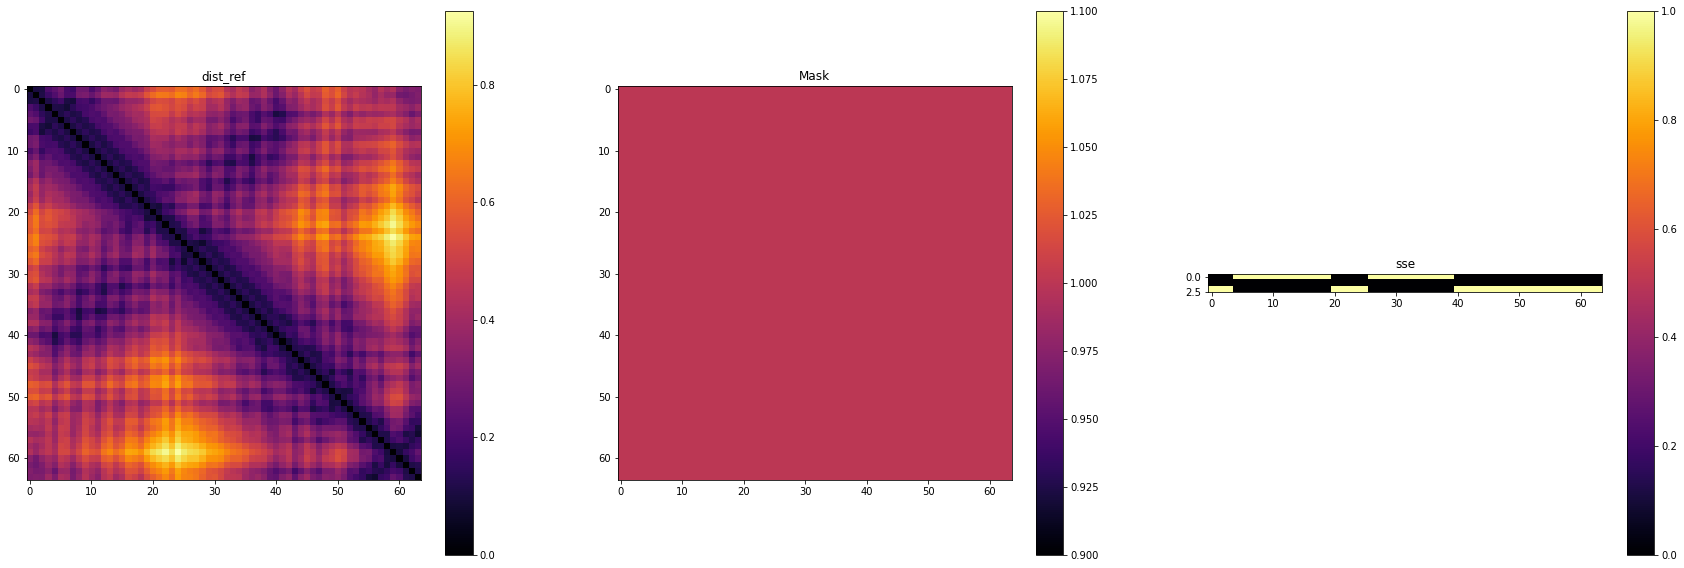

In [11]:
dist_ref,mask,sse,ref_len   = next(iter(train_data_loader))

print(dist_ref.shape,mask.shape,sse.shape,ref_len) 
ind = 0
img_list = [dist_ref[ind].squeeze().detach().cpu().numpy(),
           mask[ind].squeeze().detach().cpu().numpy(),
           sse[ind].squeeze().detach().cpu().numpy(),
           ]

title_list = ['dist_ref','Mask','sse']
plot_sub_plots(1,3,img_list,title_list,cmap = 'inferno')
print('')

## Autoencoder Model

In [12]:
class CNN_Encoder(nn.Module):
    
    def __init__(self, input_nc=1, ngf = 16):
        super(CNN_Encoder, self).__init__()
        self.enc1 = self.enc_block(in_ch = input_nc, out_ch = ngf, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )
        self.enc2 = self.enc_block(in_ch = ngf, out_ch = ngf*2, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )
        # self.enc3 = self.enc_block(in_ch = ngf*2, out_ch = ngf*4, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )
        # self.enc4 = self.enc_block(in_ch = ngf*4, out_ch = ngf*8, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )
        # self.enc5 = self.enc_block(in_ch = ngf*8, out_ch = ngf*16, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )
        
        
    def enc_block(self, in_ch, out_ch, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size,stride=stride, padding=padding, bias=bias),
                # nn.ReLU()
                )
      
            
    def forward(self, x):
        x = self.enc1(x)
        x = self.enc2(x)
        # x = self.enc3(x)
        # x = self.enc4(x)
        # x = self.enc5(x)
        return x
    

class CNN_Decoder(nn.Module):
    
    def __init__(self, lat_chan=128,out_ch = 1, ngf = 16 ):
        super(CNN_Decoder, self).__init__()
        self.dec1 = self.conv_up_block(in_ch = lat_chan , out_ch = ngf*8, 
                                       kernel_size=4, stride=2, padding = 1,bias = True)
        self.dec2 = self.conv_up_block(in_ch = ngf*8 , out_ch = 1, 
                                       kernel_size=4, stride=2, padding = 1,bias = True)
        # self.dec3 = self.conv_up_block(in_ch = ngf*4 , out_ch = ngf*2, 
        #                                kernel_size=4, stride=2, padding = 1,bias = True)
        # self.dec4 = self.conv_up_block(in_ch = ngf*2 , out_ch = 1, 
        #                                kernel_size=4, stride=2, padding = 1,bias = True)
        # self.dec5 = self.conv_up_block(in_ch = ngf , out_ch = 1, 
                                       # kernel_size=4, stride=2, padding = 1,bias = True)
        # self.final = nn.Linear(16,out_ch)
        
        
    def conv_up_block(self,  in_ch, out_ch, kernel_size=4, stride=2, padding = 1,bias = True,outermost = False):
            return nn.Sequential(
                nn.ConvTranspose2d( in_ch, out_ch, kernel_size=kernel_size, stride=stride, padding = padding,bias = bias),
                # nn.ReLU()
                )
        
    def forward(self,x): 
        x = self.dec1(x)
        
        x = self.dec2(x)
        
        
#         x = self.dec3(x)
        
#         x = self.dec4(x)
        # x = self.dec5(x)
        # x = self.final(x)
        # x = torch.moveaxis(x,-1,1)
        return x

In [13]:
enc_path = f'./model_checkpoints/Autoencoder Training Using Distoref/encoder_dist.pth.tar'
encoder = torch.load(enc_path).to(device)#CNN_Encoder(ngf = 16).to(device)#torch.load(enc_path).to(device)
encoder.eval()
print(sum([np.prod(p.size()) for p in encoder.parameters()]))

dec_path = f'./model_checkpoints/Autoencoder Training Using Distoref/decoder_dist.pth.tar'
decoder = torch.load(dec_path).to(device)#CNN_Decoder(lat_chan=32).to(device)#torch.load(dec_path).to(device)
decoder.eval()
print(sum([np.prod(p.size()) for p in decoder.parameters()]))

8496
67713


## UNet

In [14]:
class EMA:
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
        self.step = 0

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self, ema_model, model, step_start_ema=2000):
        if self.step < step_start_ema:
            self.reset_parameters(ema_model, model)
            self.step += 1
            return
        self.update_model_average(ema_model, model)
        self.step += 1

    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())


class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, device="cuda"):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128, 8)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256, 4)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256, 2)

        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128, 4)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64, 8)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64, 16)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        # print(f"x2: {x2.shape}")
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        # print(f"x3: {x3.shape}")
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        # print(f"x4: {x4.shape}")
        x4 = self.sa3(x4)
        
        # print(f"x4: {x4.shape}")
        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)
        
        # print(f"x4: {x4.shape}")
        x = self.up1(x4, x3, t)
        # print(f"x: {x.shape}")
        x = self.sa4(x)
        # print(f"x: {x.shape}")
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output
    
    
class UNet_Conditional(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, device="cuda"):#,num_classes = None):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128, 8)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256, 4)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256, 2)

        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128, 4)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64, 8)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64, 16)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)
        
#         if num_classes is not None:
#             self.label_emb = nn.Embedding(num_classes, time_dim)
        

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t,labels):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)
        # print(f"t:{t.shape}")
        if labels!=None:
            # print(self.label_emb(labels).shape)
            t = t+ labels
        
        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        # print(f"x2: {x2.shape}")
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        # print(f"x3: {x3.shape}")
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        # print(f"x4: {x4.shape}")
        x4 = self.sa3(x4)
        
        # print(f"x4: {x4.shape}")
        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)
        
        # print(f"x4: {x4.shape}")
        x = self.up1(x4, x3, t)
        # print(f"x: {x.shape}")
        x = self.sa4(x)
        # print(f"x: {x.shape}")
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output

In [15]:
model = UNet(c_in=32, c_out=32, time_dim=256, device="cuda").to(device)
# cond_enc = Cond_Encoder().to(device)
#testing
dist_ref,mask,sse,ref_len   = next(iter(train_data_loader))
# print(digit_labels.shape)

lat_c = encoder(dist_ref)
t = torch.randint(low=1, high=1000, size=(dist_ref.shape[0],)).to(device)
# labels = encoder_sse(sse.squeeze(1))
print(lat_c.shape,t.shape)#,labels.shape)

denoised_lat_c = model(lat_c,t)

print(denoised_lat_c.shape)

torch.Size([32, 32, 16, 16]) torch.Size([32])
torch.Size([32, 32, 16, 16])


## Training

In [16]:
# optimizer = optim.AdamW(list(model.parameters())+list(cond_enc.parameters()), lr=3e-4)
optimizer = optim.AdamW(model.parameters(), lr=3e-4)
mse = nn.MSELoss()
diffusion = Diffusion(img_size=[32,16,16], device=device)

In [17]:
def recon_loss(x_hat,x):
    criterion = nn.L1Loss()
    return criterion(x_hat,x)
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count if self.count != 0 else 0
        
def plot_sub_plots(rows,columns,img_list,title_list,cmap = 'inferno'):
    fig, axs = plt.subplots(rows, columns, figsize = (columns*10,rows*10))
    if rows == 1:
        for i in range(len(img_list)):
            im1 = axs[i].imshow(img_list[i],cmap=cmap)
            axs[i].set_title(f"{title_list[i]}")
            plt.colorbar(im1, ax=axs[i])#,shrink = 0.3
    else:
        for i in range(len(img_list)):
            im1 = axs[i//columns][i%columns].imshow(img_list[i],cmap=cmap)
            axs[i//columns][i%columns].set_title(f"{title_list[i]}")
            plt.colorbar(im1, ax=axs[i//columns][i%columns])#,shrink = 0.3)
    # plt.show()
    return fig

In [18]:
def train(model,diffusion,encoder,decoder,optimizer,data_loader,is_wandb=False,verbose_freq = 500,is_verbose = False):
    encoder.eval()
    decoder.eval()
    model.train()
    # cond_enc.train()
    train_losses = AverageMeter()
    for batch_idx, (x,m,sse,_ ) in enumerate(data_loader):
        x = encoder(x)#*m)
        
        
        t = diffusion.sample_timesteps(x.shape[0]).to(device)
        x_t, noise = diffusion.noise_images(x, t)
        predicted_noise = model(x_t, t)
        
        loss = mse(noise, predicted_noise) #+ recon_loss()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      
        train_losses.update(loss.data.item())
        if is_wandb:
            wandb.log({"batch_loss": loss.data.item()})
    
    
    if is_wandb:
            wandb.log({"train_epoch_loss": train_losses.avg})
            
    if is_verbose:
        print(f"Training Epoch Loss: {train_losses.avg}")
    
    x,m,sse,ref_len   = next(iter(data_loader))
    # cond_enc.eval()
    # digit_labels_2 = F.one_hot(digit_labels, num_classes=10).unsqueeze(1).float()
    # cond_vec = cond_enc(digit_labels_2.to(device))
    
    sampled_images = diffusion.sample(model, n=x.shape[0])
    sampled_images = decoder(sampled_images.float())#.clamp(min=0,max=1)
    sampled_images = sampled_images.squeeze().detach().cpu().numpy()
    print(sampled_images.shape)
    sse = sse.squeeze().detach().cpu().numpy()
    # img_list = [sampled_images[0],sse[0],sampled_images[1],sse[1],
    #             sampled_images[2],sse[2],sampled_images[3],sse[3],
    #             sampled_images[4],sse[4],sampled_images[5],sse[5],
    #             sampled_images[6],sse[6],sampled_images[7],sse[7],
    #            ] 
    
    # title_list = [ref_len[0].item(),ref_len[0].item(),ref_len[1].item(),ref_len[1].item(),
    #               ref_len[2].item(),ref_len[2].item(),ref_len[3].item(),ref_len[3].item(),
    #               ref_len[4].item(),ref_len[4].item(),ref_len[5].item(),ref_len[5].item(),
    #               ref_len[6].item(),ref_len[6].item(),ref_len[7].item(),ref_len[7].item(),]
    
    fig = plot_sub_plots(4,4,sampled_images[:16],[i for i in range (16)],cmap = 'inferno')
    if is_wandb:
            wandb.log({"examples": wandb.Image(fig)})
    
    return train_losses.avg





    # sampled_images = diffusion.sample(model, n=images.shape[0])
    # save_images(sampled_images, os.path.join("results", args.run_name, f"{epoch}.jpg"))
    # torch.save(model.state_dict(), os.path.join("models", args.run_name, f"ckpt.pt"))


In [ ]:
best_loss = 10000000
train_loss_list = []
n_epochs = 1000

# if not os.path.exists(exp_path):
#     os.mkdir(exp_path)
# print("Training ", end='')
for epoch_idx in range(n_epochs):
    # print('=', end='')
    
    train_loss = train(model,diffusion,encoder,decoder,optimizer,train_data_loader,is_wandb=is_wandb)     

    train_loss_list.append(train_loss)
    
    
    print(f"Epoch {epoch_idx+1}: {train_loss} ")
    if (train_loss < best_loss): 
        best_loss = train_loss
        # print("Saving Best Model =======================================>")
        torch.save(model, f'{exp_path}/u_net_diff.pth.tar')
        # torch.save(cond_enc, f'{exp_path}/cond_enc_diff.pth.tar')
    
                       
                       

999it [00:16, 60.78it/s]


(32, 64, 64)
Epoch 1: 0.8645999567295478 


999it [00:13, 76.63it/s] 


(32, 64, 64)
Epoch 2: 0.530591089793337 


999it [00:10, 97.47it/s] 


(32, 64, 64)
Epoch 3: 0.4080247736074091 


999it [00:10, 98.70it/s] 


(32, 64, 64)
Epoch 4: 0.3288905618151998 


999it [00:10, 91.53it/s] 


(32, 64, 64)
Epoch 5: 0.2770457686932106 


999it [00:16, 60.60it/s]


(32, 64, 64)
Epoch 6: 0.2378532275920961 


999it [00:15, 65.99it/s] 


(32, 64, 64)
Epoch 7: 0.2086578572426385 


999it [00:10, 97.89it/s] 


(32, 64, 64)
Epoch 8: 0.1839268585530723 


999it [00:10, 98.35it/s] 


(32, 64, 64)
Epoch 9: 0.1640518986112703 


999it [00:09, 102.29it/s]


(32, 64, 64)
Epoch 10: 0.1421487252644407 


999it [00:15, 63.67it/s] 


(32, 64, 64)
Epoch 11: 0.11914461045488109 


999it [00:16, 60.42it/s]


(32, 64, 64)
Epoch 12: 0.09996735928504448 


999it [00:10, 97.20it/s] 


(32, 64, 64)
Epoch 13: 0.08771467814600564 


999it [00:10, 98.42it/s] 


(32, 64, 64)
Epoch 14: 0.0775609275068694 


999it [00:10, 98.10it/s] 


(32, 64, 64)
Epoch 15: 0.07015083887712742 


999it [00:12, 79.08it/s] 


(32, 64, 64)
Epoch 16: 0.05862938349203366 


999it [00:16, 60.28it/s]


(32, 64, 64)
Epoch 17: 0.0546229317239145 


999it [00:12, 78.51it/s] 


(32, 64, 64)
Epoch 18: 0.04937005052115859 


999it [00:10, 96.74it/s] 


(32, 64, 64)
Epoch 19: 0.04182601568660116 


999it [00:10, 97.87it/s] 


(32, 64, 64)
Epoch 20: 0.03878242201436826 


999it [00:09, 102.35it/s]
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


(32, 64, 64)
Epoch 21: 0.03859046065225834 


999it [00:15, 63.71it/s] 


(32, 64, 64)
Epoch 22: 0.03481064565722051 


999it [00:16, 60.19it/s]


(32, 64, 64)
Epoch 23: 0.034158865595615005 


999it [00:10, 98.01it/s] 


(32, 64, 64)
Epoch 24: 0.033639125450234106 


999it [00:10, 97.93it/s] 


(32, 64, 64)
Epoch 25: 0.030868682752900976 


999it [00:10, 98.33it/s] 


(32, 64, 64)
Epoch 26: 0.02861321997654632 


999it [00:13, 74.60it/s] 


(32, 64, 64)
Epoch 27: 0.02702411091545733 


999it [00:16, 60.37it/s]


(32, 64, 64)
Epoch 28: 0.027156956100124655 


999it [00:12, 83.09it/s] 


(32, 64, 64)
Epoch 29: 0.026214156935854657 


999it [00:10, 98.31it/s] 


(32, 64, 64)
Epoch 30: 0.02419258961529751 


999it [00:10, 98.17it/s] 


(32, 64, 64)
Epoch 31: 0.024040265039094094 


999it [00:10, 99.55it/s] 


(32, 64, 64)
Epoch 32: 0.023193314421649385 


999it [00:16, 60.08it/s]


(32, 64, 64)
Epoch 33: 0.02210679451170249 


999it [00:14, 66.67it/s] 


(32, 64, 64)
Epoch 34: 0.022217245507470475 


999it [00:10, 97.60it/s] 


(32, 64, 64)
Epoch 35: 0.020335604012678792 


999it [00:10, 98.90it/s] 


(32, 64, 64)
Epoch 36: 0.01983606476881882 


999it [00:09, 101.74it/s]


(32, 64, 64)
Epoch 37: 0.019324865654050335 


999it [00:14, 69.77it/s] 


(32, 64, 64)
Epoch 38: 0.019937626033173343 


999it [00:16, 60.32it/s]


(32, 64, 64)
Epoch 39: 0.018886370463221055 


999it [00:12, 80.09it/s] 


(32, 64, 64)
Epoch 40: 0.01801055656912608 


999it [00:10, 97.74it/s] 


(32, 64, 64)
Epoch 41: 0.018620345173630773 


999it [00:10, 99.54it/s] 


(32, 64, 64)
Epoch 42: 0.018276056373204157 


999it [00:10, 91.22it/s] 


(32, 64, 64)
Epoch 43: 0.018567251208109585 


999it [00:16, 60.36it/s]


(32, 64, 64)
Epoch 44: 0.017927121416461175 


999it [00:14, 67.76it/s] 


(32, 64, 64)
Epoch 45: 0.017284017328808948 


999it [00:10, 98.22it/s] 


(32, 64, 64)
Epoch 46: 0.01745954377016401 


999it [00:10, 98.63it/s] 


(32, 64, 64)
Epoch 47: 0.016573175250333014 


999it [00:09, 100.25it/s]


(32, 64, 64)
Epoch 48: 0.016224122386637743 


999it [00:11, 86.95it/s] 


(32, 64, 64)
Epoch 49: 0.015326108124743148 


999it [00:16, 60.47it/s]


(32, 64, 64)
Epoch 50: 0.016734076671423466 


999it [00:13, 74.14it/s] 


(32, 64, 64)
Epoch 51: 0.015283650393045045 


999it [00:10, 99.16it/s] 


(32, 64, 64)
Epoch 52: 0.015932945504299995 


999it [00:10, 98.90it/s] 


(32, 64, 64)
Epoch 53: 0.017078744027975615 


999it [00:10, 97.20it/s] 


(32, 64, 64)
Epoch 54: 0.015154215158909802 


999it [00:16, 60.70it/s]


(32, 64, 64)
Epoch 55: 0.014997373766651967 


999it [00:16, 59.56it/s]


(32, 64, 64)
Epoch 56: 0.014469453527372542 


999it [00:10, 98.76it/s] 


(32, 64, 64)
Epoch 57: 0.014897334412103745 


999it [00:10, 98.61it/s] 


(32, 64, 64)
Epoch 58: 0.015326809342496278 


999it [00:09, 101.05it/s]


(32, 64, 64)
Epoch 59: 0.015097816671600671 


999it [00:14, 71.04it/s] 


(32, 64, 64)
Epoch 60: 0.015166167722545504 


999it [00:16, 60.16it/s]


(32, 64, 64)
Epoch 61: 0.013591976071579186 


999it [00:13, 73.37it/s] 


(32, 64, 64)
Epoch 62: 0.014066386657456556 


999it [00:10, 98.17it/s] 


(32, 64, 64)
Epoch 63: 0.014331783819186494 


999it [00:10, 98.78it/s] 


(32, 64, 64)
Epoch 64: 0.01408507172926897 


999it [00:09, 103.31it/s]


(32, 64, 64)
Epoch 65: 0.013806603493062945 


999it [00:14, 66.72it/s] 


(32, 64, 64)
Epoch 66: 0.015011177496696875 


999it [00:16, 60.34it/s]


(32, 64, 64)
Epoch 67: 0.012611909201595842 


999it [00:10, 99.05it/s] 


(32, 64, 64)
Epoch 68: 0.013662819970187133 


999it [00:10, 99.86it/s] 


(32, 64, 64)
Epoch 69: 0.01482011399012271 


999it [00:10, 98.62it/s] 


(32, 64, 64)
Epoch 70: 0.013416171020911477 


999it [00:08, 121.83it/s]


(32, 64, 64)
Epoch 71: 0.012877437884245462 


999it [00:08, 120.86it/s]


(32, 64, 64)
Epoch 72: 0.013970934233166338 


999it [00:08, 122.32it/s]


(32, 64, 64)
Epoch 73: 0.0141067677896803 


999it [00:08, 120.58it/s]


(32, 64, 64)
Epoch 74: 0.012976800935812355 


999it [00:08, 120.78it/s]


(32, 64, 64)
Epoch 75: 0.013596252038529733 


999it [00:08, 121.78it/s]


(32, 64, 64)
Epoch 76: 0.012591978012606865 


999it [00:08, 121.42it/s]


(32, 64, 64)
Epoch 77: 0.013331987656562067 


999it [00:08, 121.68it/s]


(32, 64, 64)
Epoch 78: 0.013213484744897218 


999it [00:08, 119.85it/s]


(32, 64, 64)
Epoch 79: 0.012298324342241616 


999it [00:08, 121.57it/s]


(32, 64, 64)
Epoch 80: 0.012511093010444467 


999it [00:08, 121.70it/s]


(32, 64, 64)
Epoch 81: 0.012729222712114574 


999it [00:08, 121.86it/s]


(32, 64, 64)
Epoch 82: 0.013209557406816298 


999it [00:08, 122.08it/s]


(32, 64, 64)
Epoch 83: 0.012229134483883778 


999it [00:08, 121.58it/s]


(32, 64, 64)
Epoch 84: 0.012304599162160866 


999it [00:08, 121.57it/s]


(32, 64, 64)
Epoch 85: 0.012145265713485518 


999it [00:08, 121.49it/s]


(32, 64, 64)
Epoch 86: 0.012205593518882505 


999it [00:08, 119.85it/s]


(32, 64, 64)
Epoch 87: 0.011489481600834345 


999it [00:08, 121.93it/s]


(32, 64, 64)
Epoch 88: 0.012676846156487377 


999it [00:08, 121.81it/s]


(32, 64, 64)
Epoch 89: 0.013047532416970991 


999it [00:08, 120.63it/s]


(32, 64, 64)
Epoch 90: 0.012607031172459445 


999it [00:08, 121.52it/s]


(32, 64, 64)
Epoch 91: 0.01176745890511003 


999it [00:08, 119.73it/s]


(32, 64, 64)
Epoch 92: 0.012182993927925097 


999it [00:08, 118.88it/s]


(32, 64, 64)
Epoch 93: 0.012121139177522524 


999it [00:08, 121.92it/s]


(32, 64, 64)
Epoch 94: 0.011682601111782034 


999it [00:08, 122.08it/s]


(32, 64, 64)
Epoch 95: 0.01251441728687141 


999it [00:08, 121.72it/s]


(32, 64, 64)
Epoch 96: 0.011264595740694341 


999it [00:08, 121.96it/s]


(32, 64, 64)
Epoch 97: 0.012123004506849418 


999it [00:08, 122.59it/s]


(32, 64, 64)
Epoch 98: 0.011838557690806021 


999it [00:08, 121.91it/s]


(32, 64, 64)
Epoch 99: 0.012310420723283678 


999it [00:08, 121.98it/s]


(32, 64, 64)
Epoch 100: 0.01133548081814637 


999it [00:08, 122.06it/s]


(32, 64, 64)
Epoch 101: 0.010748334202491413 


999it [00:08, 120.21it/s]


(32, 64, 64)
Epoch 102: 0.011492662983605774 


999it [00:08, 121.30it/s]


(32, 64, 64)
Epoch 103: 0.011942114150984501 


999it [00:08, 121.42it/s]


(32, 64, 64)
Epoch 104: 0.011485981100004136 


999it [00:08, 122.27it/s]


(32, 64, 64)
Epoch 105: 0.011598692192294733 


999it [00:08, 120.38it/s]


(32, 64, 64)
Epoch 106: 0.01124198452713407 


999it [00:08, 121.66it/s]


(32, 64, 64)
Epoch 107: 0.010958309735860525 


999it [00:08, 122.58it/s]


(32, 64, 64)
Epoch 108: 0.01159172669825394 


999it [00:08, 121.35it/s]


(32, 64, 64)
Epoch 109: 0.011693161700254048 


999it [00:08, 121.95it/s]


(32, 64, 64)
Epoch 110: 0.011415886295187036 


999it [00:08, 120.62it/s]


(32, 64, 64)
Epoch 111: 0.010399312189802891 


999it [00:08, 122.10it/s]


(32, 64, 64)
Epoch 116: 0.011384961411084344 


999it [00:08, 121.77it/s]


(32, 64, 64)
Epoch 117: 0.010660889463847488 


999it [00:08, 121.95it/s]


(32, 64, 64)
Epoch 118: 0.011096652998490547 


999it [00:08, 121.86it/s]


(32, 64, 64)
Epoch 119: 0.010477431720440708 


999it [00:08, 120.74it/s]


(32, 64, 64)
Epoch 120: 0.010976428060027642 


999it [00:08, 121.55it/s]


(32, 64, 64)
Epoch 121: 0.010857349734874518 


999it [00:08, 121.78it/s]


(32, 64, 64)
Epoch 122: 0.01222400096192108 


999it [00:08, 121.91it/s]


(32, 64, 64)
Epoch 123: 0.010815524038048537 


999it [00:08, 121.38it/s]


(32, 64, 64)
Epoch 124: 0.010664417393263279 


999it [00:08, 121.05it/s]


(32, 64, 64)
Epoch 125: 0.011403338737573808 


999it [00:08, 121.20it/s]


(32, 64, 64)
Epoch 126: 0.0107633724611828 


999it [00:08, 121.94it/s]


(32, 64, 64)
Epoch 127: 0.010581943528287537 


999it [00:08, 122.25it/s]


(32, 64, 64)
Epoch 128: 0.010827530183019192 


999it [00:08, 122.54it/s]


(32, 64, 64)
Epoch 129: 0.01073526692145118 


999it [00:08, 122.70it/s]


(32, 64, 64)
Epoch 130: 0.010627082666397338 


999it [00:08, 122.92it/s]


(32, 64, 64)
Epoch 131: 0.010473589999676963 


999it [00:08, 122.10it/s]


(32, 64, 64)
Epoch 132: 0.010174973746685962 


999it [00:08, 121.91it/s]


(32, 64, 64)
Epoch 133: 0.01004911575284673 


999it [00:08, 120.95it/s]


(32, 64, 64)
Epoch 134: 0.011108698633809885 


999it [00:08, 121.34it/s]


(32, 64, 64)
Epoch 135: 0.010080874931612393 


999it [00:08, 122.56it/s]


(32, 64, 64)
Epoch 136: 0.010528836066160745 


999it [00:08, 120.75it/s]


(32, 64, 64)
Epoch 137: 0.010014869011484268 


999it [00:08, 120.93it/s]


(32, 64, 64)
Epoch 138: 0.010222794817442574 


999it [00:08, 122.44it/s]


(32, 64, 64)
Epoch 139: 0.01094256035938132 


999it [00:08, 122.36it/s]


(32, 64, 64)
Epoch 140: 0.010802961749637999 


999it [00:08, 121.62it/s]


(32, 64, 64)
Epoch 141: 0.01008692510214036 


999it [00:08, 121.47it/s]


(32, 64, 64)
Epoch 142: 0.009509401528422183 


999it [00:08, 121.62it/s]


(32, 64, 64)
Epoch 143: 0.010010187324833095 


999it [00:08, 122.53it/s]


(32, 64, 64)
Epoch 144: 0.009483040401303187 


999it [00:08, 122.51it/s]


(32, 64, 64)
Epoch 145: 0.010070576222719459 


999it [00:08, 120.56it/s]


(32, 64, 64)
Epoch 146: 0.010439095961884028 


999it [00:08, 121.88it/s]


(32, 64, 64)
Epoch 147: 0.010260104387241408 


999it [00:08, 122.07it/s]


(32, 64, 64)
Epoch 148: 0.009651278395478318 


999it [00:08, 122.13it/s]


(32, 64, 64)
Epoch 149: 0.009882707909749048 


999it [00:08, 122.16it/s]


(32, 64, 64)
Epoch 150: 0.010837872327131227 


999it [00:08, 121.92it/s]


(32, 64, 64)
Epoch 151: 0.010786827699076839 


620it [00:05, 118.84it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

999it [00:08, 121.25it/s]


(32, 64, 64)
Epoch 415: 0.006146343048222787 


999it [00:08, 122.68it/s]


(32, 64, 64)
Epoch 416: 0.0062228850641749735 


999it [00:08, 123.00it/s]


(32, 64, 64)
Epoch 417: 0.006534142913751122 


999it [00:08, 120.96it/s]


(32, 64, 64)
Epoch 418: 0.006562580903462036 


999it [00:08, 123.17it/s]


(32, 64, 64)
Epoch 419: 0.0068644910607850405 


999it [00:08, 122.41it/s]


(32, 64, 64)
Epoch 420: 0.006182010100048974 


999it [00:08, 122.06it/s]


(32, 64, 64)
Epoch 421: 0.006724598111463635 


999it [00:08, 120.92it/s]


(32, 64, 64)
Epoch 422: 0.006248179673618539 


999it [00:08, 121.17it/s]


(32, 64, 64)
Epoch 423: 0.006697217517388545 


999it [00:08, 122.44it/s]


(32, 64, 64)
Epoch 424: 0.007072986803979166 


999it [00:08, 121.50it/s]


(32, 64, 64)
Epoch 425: 0.006964119596073661 


999it [00:08, 120.57it/s]


(32, 64, 64)
Epoch 426: 0.007115323889652282 


999it [00:08, 121.54it/s]


(32, 64, 64)
Epoch 427: 0.006860408884647295 


999it [00:08, 122.93it/s]


(32, 64, 64)
Epoch 428: 0.006559736511813916 


999it [00:08, 122.19it/s]


(32, 64, 64)
Epoch 429: 0.011596828852439435 


999it [00:08, 121.92it/s]


(32, 64, 64)
Epoch 430: 0.0071266058915696005 


999it [00:08, 122.58it/s]


(32, 64, 64)
Epoch 431: 0.006804403814873318 


999it [00:08, 122.81it/s]


(32, 64, 64)
Epoch 432: 0.0064891695662030605 


999it [00:08, 122.89it/s]


(32, 64, 64)
Epoch 433: 0.005906598557286509 


999it [00:08, 122.40it/s]


(32, 64, 64)
Epoch 434: 0.005997882809535396 


999it [00:08, 122.53it/s]


(32, 64, 64)
Epoch 435: 0.006791867262767098 


999it [00:08, 121.80it/s]


(32, 64, 64)
Epoch 436: 0.006212609980967108 


999it [00:08, 121.96it/s]


(32, 64, 64)
Epoch 437: 0.006860925303014919 


999it [00:08, 121.87it/s]


(32, 64, 64)
Epoch 438: 0.007597859678184235 


999it [00:08, 122.91it/s]


(32, 64, 64)
Epoch 439: 0.006268129314909257 


999it [00:08, 122.23it/s]


(32, 64, 64)
Epoch 440: 0.006605836878931983 


999it [00:08, 122.85it/s]


(32, 64, 64)
Epoch 441: 0.006350430493371758 


999it [00:08, 122.65it/s]


(32, 64, 64)
Epoch 442: 0.0059513730769295515 


999it [00:08, 122.32it/s]


(32, 64, 64)
Epoch 443: 0.006372200258878794 


999it [00:08, 122.43it/s]


(32, 64, 64)
Epoch 444: 0.006558239834792003 


999it [00:08, 122.63it/s]


(32, 64, 64)
Epoch 445: 0.006711146411887272 


999it [00:08, 122.42it/s]


(32, 64, 64)
Epoch 446: 0.006428137745299354 


999it [00:08, 122.71it/s]


(32, 64, 64)
Epoch 447: 0.006172273720697901 


999it [00:08, 122.42it/s]


(32, 64, 64)
Epoch 448: 0.006692318739823815 


999it [00:08, 122.67it/s]


(32, 64, 64)
Epoch 449: 0.006108435838127403 


999it [00:08, 121.66it/s]


(32, 64, 64)
Epoch 450: 0.0063632862430399026 


999it [00:08, 122.36it/s]


(32, 64, 64)
Epoch 451: 0.006037463882665445 


295it [00:02, 123.91it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

999it [00:08, 122.08it/s]


(32, 64, 64)
Epoch 546: 0.005636435369317367 


999it [00:08, 123.15it/s]


(32, 64, 64)
Epoch 552: 0.005929301648090283 


999it [00:08, 122.43it/s]


(32, 64, 64)
Epoch 553: 0.005428997973903892 


999it [00:08, 122.27it/s]


(32, 64, 64)
Epoch 554: 0.005805126561715108 


999it [00:08, 123.05it/s]


(32, 64, 64)
Epoch 555: 0.005988007314821206 


999it [00:08, 122.88it/s]


(32, 64, 64)
Epoch 556: 0.006113274577565915 


999it [00:08, 122.10it/s]


(32, 64, 64)
Epoch 557: 0.005568232406233627 


999it [00:08, 122.40it/s]


(32, 64, 64)
Epoch 558: 0.005741419815799085 


999it [00:08, 121.58it/s]


(32, 64, 64)
Epoch 559: 0.006052057520009395 


999it [00:08, 121.53it/s]


(32, 64, 64)
Epoch 560: 0.0054657337997805295 


999it [00:08, 122.72it/s]


(32, 64, 64)
Epoch 561: 0.006023467209841299 


999it [00:08, 121.28it/s]


(32, 64, 64)
Epoch 562: 0.005602986610502126 


999it [00:08, 123.15it/s]


(32, 64, 64)
Epoch 563: 0.006226411104444566 


999it [00:08, 122.82it/s]


(32, 64, 64)
Epoch 564: 0.006030444192086778 


999it [00:08, 122.04it/s]


(32, 64, 64)
Epoch 565: 0.006374215635251466 


999it [00:08, 123.34it/s]


(32, 64, 64)
Epoch 566: 0.0053499521502119495 


999it [00:08, 121.68it/s]


(32, 64, 64)
Epoch 567: 0.005446582059640952 


999it [00:08, 122.02it/s]


(32, 64, 64)
Epoch 568: 0.006346735037575529 


999it [00:08, 121.43it/s]


(32, 64, 64)
Epoch 569: 0.005356272686333433 


999it [00:08, 122.49it/s]


(32, 64, 64)
Epoch 570: 0.006862106254112308 


999it [00:08, 122.05it/s]


(32, 64, 64)
Epoch 571: 0.00576642831424024 


999it [00:08, 122.53it/s]


(32, 64, 64)
Epoch 572: 0.005353707611954551 


999it [00:08, 121.71it/s]


(32, 64, 64)
Epoch 573: 0.0055345012635992065 


999it [00:08, 122.02it/s]


(32, 64, 64)
Epoch 574: 0.005821600281898447 


999it [00:08, 121.85it/s]


(32, 64, 64)
Epoch 575: 0.005364821761907116 


999it [00:08, 121.36it/s]


(32, 64, 64)
Epoch 576: 0.006714113987982273 


999it [00:08, 121.52it/s]


(32, 64, 64)
Epoch 577: 0.009054128478122194 


999it [00:08, 122.86it/s]


(32, 64, 64)
Epoch 578: 0.006007730101454791 


999it [00:08, 122.21it/s]


(32, 64, 64)
Epoch 579: 0.005660027248512317 


999it [00:08, 123.19it/s]


(32, 64, 64)
Epoch 580: 0.005365882304542493 


999it [00:08, 123.00it/s]


(32, 64, 64)
Epoch 581: 0.006120285871097955 


999it [00:08, 122.25it/s]


(32, 64, 64)
Epoch 582: 0.005571973142857716 


999it [00:08, 121.71it/s]


(32, 64, 64)
Epoch 583: 0.005272729100841211 


999it [00:08, 121.95it/s]


(32, 64, 64)
Epoch 584: 0.005220144576340065 


999it [00:08, 122.45it/s]


(32, 64, 64)
Epoch 585: 0.006030735504866495 


999it [00:08, 122.18it/s]


(32, 64, 64)
Epoch 586: 0.005397069336074155 


999it [00:08, 122.65it/s]


(32, 64, 64)
Epoch 587: 0.00574339910342199 


999it [00:08, 118.54it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

999it [00:08, 123.03it/s]


(32, 64, 64)
Epoch 730: 0.005297956811226298 


999it [00:08, 121.58it/s]


(32, 64, 64)
Epoch 731: 0.005764576034786982 


999it [00:08, 122.80it/s]


(32, 64, 64)
Epoch 732: 0.0060294332054663235 


999it [00:08, 121.71it/s]


(32, 64, 64)
Epoch 733: 0.0054629823548825295 


999it [00:08, 122.74it/s]


(32, 64, 64)
Epoch 734: 0.0052225875717443904 


999it [00:08, 122.41it/s]


(32, 64, 64)
Epoch 735: 0.005641676186455217 


999it [00:08, 120.71it/s]


(32, 64, 64)
Epoch 736: 0.0060472696578523855 


999it [00:08, 122.69it/s]


(32, 64, 64)
Epoch 737: 0.005925036376205887 


999it [00:08, 122.31it/s]


(32, 64, 64)
Epoch 738: 0.005537559001941264 


999it [00:08, 122.97it/s]


(32, 64, 64)
Epoch 739: 0.005221448151576446 


999it [00:08, 122.96it/s]


(32, 64, 64)
Epoch 740: 0.004693744360560142 


999it [00:08, 122.43it/s]


(32, 64, 64)
Epoch 741: 0.005298422751721085 


999it [00:08, 121.67it/s]


(32, 64, 64)
Epoch 742: 0.004888584975501507 


999it [00:08, 122.17it/s]


(32, 64, 64)
Epoch 743: 0.005294732310301889 


999it [00:08, 122.86it/s]


(32, 64, 64)
Epoch 744: 0.005566588369183 


999it [00:08, 121.65it/s]


(32, 64, 64)
Epoch 745: 0.0052371318130261775 


999it [00:08, 123.42it/s]


(32, 64, 64)
Epoch 746: 0.005249580488600806 


999it [00:08, 122.65it/s]


(32, 64, 64)
Epoch 747: 0.0052052614898080145 


999it [00:08, 122.33it/s]


(32, 64, 64)
Epoch 748: 0.005487025781663332 


999it [00:08, 121.33it/s]


(32, 64, 64)
Epoch 749: 0.005138011609499411 


999it [00:08, 121.81it/s]


(32, 64, 64)
Epoch 750: 0.0051423209289664295 


999it [00:08, 122.52it/s]


(32, 64, 64)
Epoch 751: 0.006032366251641112 


999it [00:08, 122.33it/s]


(32, 64, 64)
Epoch 752: 0.005041202051353042 


999it [00:08, 122.60it/s]


(32, 64, 64)
Epoch 753: 0.005086665567033357 


999it [00:08, 122.54it/s]


(32, 64, 64)
Epoch 754: 0.005323701021375089 


999it [00:08, 122.48it/s]


(32, 64, 64)
Epoch 755: 0.005141893356311612 


999it [00:08, 122.28it/s]


(32, 64, 64)
Epoch 756: 0.004887275526496938 


999it [00:08, 121.82it/s]


(32, 64, 64)
Epoch 757: 0.005044632241114732 


999it [00:08, 122.22it/s]


(32, 64, 64)
Epoch 758: 0.005307876469938432 


999it [00:08, 120.99it/s]


(32, 64, 64)
Epoch 759: 0.005474745602596824 


999it [00:08, 122.67it/s]


(32, 64, 64)
Epoch 760: 0.0051218022978523885 


999it [00:08, 121.68it/s]


(32, 64, 64)
Epoch 761: 0.005988203735863108 


999it [00:08, 121.11it/s]


(32, 64, 64)
Epoch 762: 0.005122858484851091 


999it [00:08, 122.13it/s]


(32, 64, 64)
Epoch 763: 0.005025853954702313 


999it [00:08, 123.74it/s]


(32, 64, 64)
Epoch 764: 0.0051390176243338035 


999it [00:08, 122.22it/s]


(32, 64, 64)
Epoch 765: 0.005007405277924627 


621it [00:05, 124.10it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

999it [00:08, 121.62it/s]


(32, 64, 64)
Epoch 852: 0.005441392451994181 


999it [00:08, 122.04it/s]


(32, 64, 64)
Epoch 853: 0.0049132920178864906 


999it [00:08, 122.49it/s]


(32, 64, 64)
Epoch 854: 0.005108064716318395 


999it [00:08, 123.00it/s]


(32, 64, 64)
Epoch 855: 0.0049020290484545915 


999it [00:08, 123.44it/s]


(32, 64, 64)
Epoch 856: 0.005102337875623044 


999it [00:08, 122.31it/s]


(32, 64, 64)
Epoch 857: 0.0053879574018840986 


999it [00:08, 122.93it/s]


(32, 64, 64)
Epoch 858: 0.005623261629777953 


999it [00:08, 121.97it/s]


(32, 64, 64)
Epoch 859: 0.005429315350465174 


999it [00:08, 123.21it/s]


(32, 64, 64)
Epoch 860: 0.004801913351956301 


999it [00:08, 123.28it/s]


(32, 64, 64)
Epoch 861: 0.005254626723680251 


999it [00:08, 121.89it/s]


(32, 64, 64)
Epoch 862: 0.005247959263274461 


999it [00:08, 122.82it/s]


(32, 64, 64)
Epoch 863: 0.004981956302710786 


999it [00:08, 121.61it/s]


(32, 64, 64)
Epoch 864: 0.005140211895047649 


999it [00:08, 121.33it/s]


(32, 64, 64)
Epoch 865: 0.004454755317041181 


999it [00:08, 122.45it/s]


(32, 64, 64)
Epoch 866: 0.004963004114522743 


999it [00:08, 122.45it/s]


(32, 64, 64)
Epoch 867: 0.004738571230185832 


999it [00:08, 122.04it/s]


(32, 64, 64)
Epoch 868: 0.004768898281859371 


999it [00:08, 122.94it/s]


(32, 64, 64)
Epoch 869: 0.004719057107132261 


999it [00:08, 123.95it/s]


(32, 64, 64)
Epoch 870: 0.004645099406266903 


999it [00:08, 123.12it/s]


(32, 64, 64)
Epoch 871: 0.004711405910755985 


999it [00:08, 122.13it/s]


(32, 64, 64)
Epoch 872: 0.004835506116524641 


999it [00:08, 122.80it/s]


(32, 64, 64)
Epoch 873: 0.004670735638838534 


999it [00:08, 123.28it/s]


(32, 64, 64)
Epoch 874: 0.004388295877838462 


999it [00:08, 122.11it/s]


(32, 64, 64)
Epoch 875: 0.004886283922554334 


999it [00:08, 122.37it/s]


(32, 64, 64)
Epoch 876: 0.004852950021177833 


999it [00:08, 122.27it/s]


(32, 64, 64)
Epoch 877: 0.004929197842361239 


999it [00:08, 122.63it/s]


(32, 64, 64)
Epoch 878: 0.00503280333421246 


999it [00:08, 120.45it/s]


(32, 64, 64)
Epoch 879: 0.006072650396651248 


999it [00:08, 122.53it/s]


(32, 64, 64)
Epoch 880: 0.00519914420537378 


999it [00:08, 123.14it/s]


(32, 64, 64)
Epoch 881: 0.005302105258915543 


999it [00:08, 123.63it/s]


(32, 64, 64)
Epoch 882: 0.004920416956434284 


999it [00:08, 121.84it/s]


(32, 64, 64)
Epoch 883: 0.005094279055256487 


999it [00:08, 121.92it/s]


(32, 64, 64)
Epoch 884: 0.005329150117827746 


999it [00:08, 121.51it/s]


(32, 64, 64)
Epoch 885: 0.004689540349636075 


999it [00:08, 123.19it/s]


(32, 64, 64)
Epoch 886: 0.004975546158024874 


999it [00:08, 121.15it/s]


(32, 64, 64)
Epoch 887: 0.004779418399443895 


620it [00:05, 121.53it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

999it [00:08, 124.62it/s]


(32, 64, 64)
Epoch 980: 0.0051697126241415986 


999it [00:08, 124.58it/s]


(32, 64, 64)
Epoch 981: 0.004196894958963603 


999it [00:08, 124.54it/s]


(32, 64, 64)
Epoch 982: 0.004757575450343936 


999it [00:08, 124.76it/s]


(32, 64, 64)
Epoch 983: 0.004748647060525429 


999it [00:08, 124.51it/s]


(32, 64, 64)
Epoch 984: 0.005066306969128185 


999it [00:08, 124.68it/s]


(32, 64, 64)
Epoch 985: 0.005119711465421852 


999it [00:08, 124.43it/s]


(32, 64, 64)
Epoch 986: 0.004462939855544184 


999it [00:08, 124.07it/s]


(32, 64, 64)
Epoch 987: 0.004831317251896471 


999it [00:08, 123.81it/s]


(32, 64, 64)
Epoch 988: 0.004944569143519654 


999it [00:08, 123.51it/s]


(32, 64, 64)
Epoch 989: 0.004735793559660575 


999it [00:08, 124.07it/s]


(32, 64, 64)
Epoch 990: 0.004358476819091938 


999it [00:08, 124.75it/s]


(32, 64, 64)
Epoch 991: 0.0045483130497888215 


999it [00:08, 124.07it/s]


(32, 64, 64)
Epoch 992: 0.004461389545131687 


999it [00:08, 124.55it/s]


(32, 64, 64)
Epoch 993: 0.004930031599431503 


999it [00:08, 124.41it/s]


(32, 64, 64)
Epoch 994: 0.004628503176466963 


999it [00:08, 124.27it/s]


(32, 64, 64)
Epoch 995: 0.005022662737202354 


999it [00:08, 124.18it/s]


(32, 64, 64)
Epoch 996: 0.004723687339157653 
